# Custom Training with TensorFlow in Sagemaker

# Download Data

In [1]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
# import subprocess
# subprocess.call(['pip', 'install', 'tensorflow'])
import tensorflow as tf
import sagemaker

from PIL import Image
from matplotlib import pyplot as plt

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

print('Libraries imported')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Libraries imported


In [2]:
def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

def get_annotations(file_path, annotations={}):
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        class_name = image_name.split('_')[:-1]
        class_name = '_'.join(class_name)
        image_name = image_name + '.jpg'
        
        annotations[image_name] = 'cat' if class_name[0] != class_name[0].lower() else 'dog'
    
    return annotations

In [3]:
if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

# Dataset for Training

In [4]:
annotations = get_annotations('data/annotations/trainval.txt')
annotations = get_annotations('data/annotations/test.txt', annotations)

total_count = len(annotations.keys())
print('Total examples', total_count)

Total examples 7349


In [5]:
next(iter(annotations.items()))

('Abyssinian_100.jpg', 'cat')

In [6]:
classes = ['cat', 'dog']
sets = ['train', 'validation']
root_dir = 'custom_data'

if not os.path.isdir(root_dir):
    os.mkdir(root_dir)
    
for set_name in sets:
    if not os.path.isdir(os.path.join(root_dir, set_name)):
        os.mkdir(os.path.join(root_dir, set_name))
    for class_name in classes:
        folder = os.path.join(root_dir, set_name, class_name)
        if not os.path.isdir(folder):
            os.mkdir(folder)

Copy the files to correct set/ class folders

In [7]:
for image, class_name in annotations.items():
    target_set = 'validation' if random.randint(0, 99) < 20 else 'train'
    target_path = os.path.join(root_dir, target_set, class_name, image)
    shutil.copy(os.path.join('data/images/', image), target_path)

In [8]:
sets_counts = {
    'train': 0,
    'validation': 0
}

for set_name in sets:
    for class_name in classes:
        path = os.path.join(root_dir, set_name, class_name)
        count = len(os.listdir(path))
        print(path, 'has', count, 'images')
        sets_counts[set_name] += count

print(sets_counts)

custom_data/train/cat has 1904 images
custom_data/train/dog has 3990 images
custom_data/validation/cat has 467 images
custom_data/validation/dog has 988 images
{'train': 5894, 'validation': 1455}


# Training Script - Create Model

In [9]:
%%writefile train.py

import tensorflow as tf
import argparse
import os
import json

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,
                                                      pooling = 'avg', weights='imagenet',
                                                      input_shape=(128, 128, 3)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = 'sigmoid')  
    ])
    model.layers[0].trainable = False
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

Writing train.py


# Training Script - Data Generators

In [10]:
%%writefile -a train.py

def create_data_generators(root_dir, batch_size):
    train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        # USE for input pre process images.
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        # Data agumentation
        horizontal_flip=True,
        zoom_range=[0.8, 1.2],
        rotation_range=20
    ).flow_from_directory(
        os.path.join(root_dir, 'train'),
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        # USE for input pre process images.
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        # no Data agumentation
#         horizontal_flip=True,
#         zoom_range=[0.8, 1.2],
#         rotation_range=20
    ).flow_from_directory(
        os.path.join(root_dir, 'validation'),
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )
    return train_data_generator, val_data_generator

Appending to train.py


# Training Script - Putting it Together

In [11]:
%%writefile -a train.py

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--epochs', type=int, default=3)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--steps', type=int, default=int(5884/16))
    parser.add_argument('--val_steps', type=int, default=int(1465/16))
    # Dir model artifect once taining job is finished
    parser.add_argument('--model_dir', type=str)
    # Dir our local model after the traing will be stored
    parser.add_argument('--sm-model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    # data channel pass to scrpit
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))
    # pass the all the argument we gave set above
    args, _ = parser.parse_known_args()
    #loacl output dir to save model
    local_output_dir = args.sm_model_dir
    #root dir for data channel
    local_root_dir = args.train
    batch_size = args.batch_size
    
    model = create_model()
    train_gen, val_gen = create_data_generators(local_root_dir, batch_size)
    
    _= model.fit(
       train_gen,
       epochs= args.epochs,
       steps_per_epoch=args.steps,
       validation_data=val_gen,
       validation_steps=args.val_steps
    )
    
    # save local output dir
    model.save(os.path.join(local_output_dir, 'model', '1'))

Appending to train.py


# Upload Dataset to S3

In [13]:
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket_name='customtf'

print('uploading data to S3')
s3_data_path=sess.upload_data(path=root_dir, bucket=bucket_name, key_prefix='data')
print('uploaded to', s3_data_path)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
uploading data to S3
uploaded to s3://customtf/data


# Train with TensorFlow Estimator

In [14]:
from sagemaker.tensorflow import TensorFlow

pets_estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    train_instance_type='ml.m5.xlarge',
    train_instance_count=1,
    framework_version='2.1.0',
    py_version='py3',
    output_path='s3://customtf/'
)

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [21]:
pets_estimator.fit(s3_data_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-11-22-15-17-57-994


2023-11-22 15:17:58 Starting - Starting the training job...
2023-11-22 15:18:26 Starting - Preparing the instances for training.........
2023-11-22 15:19:36 Downloading - Downloading input data......
2023-11-22 15:20:52 Training - Training image download completed. Training in progress..2023-11-22 15:20:54,697 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2023-11-22 15:20:54,705 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-11-22 15:20:54,920 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-11-22 15:20:54,936 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-11-22 15:20:54,954 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-11-22 15:20:54,965 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/inpu

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 96/367 [======>.......................] - ETA: 59s - loss: 0.5454 - accuracy: 0.7435#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 97/367 [======>.......................] - ETA: 59s - loss: 0.5461 - accuracy: 0.7448#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015192/367 [==============>...............] - ETA: 35s - loss: 0.4463 - accuracy: 0.7913#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015193/367 [==============>...............] - ETA: 35s - loss: 0.4456 - accuracy: 0.7917#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

 loss: 0.4024 - accuracy: 0.8147#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015288/367 [======================>.......] - ETA: 15s - loss: 0.4019 - accuracy: 0.8149#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015289/367 [======================>.......] - ETA: 15s - loss: 0.4026 - accuracy: 0.8151#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015  1/367 [..............................] - ETA: 1:40 - loss: 0.2817 - accuracy: 0.8750#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  2/367 [..............................] - ETA: 1:23 - loss: 0.2034 - accuracy: 0.9062#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  3/367 [..............................] - ETA: 1:17 - loss: 0.2638 - accuracy: 0.8958#010#010#010#010#010#010#010#010#010#010#0

A: 50s - loss: 0.2627 - accuracy: 0.8860#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 97/367 [======>.......................] - ETA: 50s - loss: 0.2633 - accuracy: 0.8859#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 98/367 [=======>......................] - ETA: 50s - loss: 0.2646 - accuracy: 0.8858#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

==========>...............] - ETA: 33s - loss: 0.2742 - accuracy: 0.8808#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015193/367 [==============>...............] - ETA: 33s - loss: 0.2740 - accuracy: 0.8804#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015194/367 [==============>...............] - ETA: 33s - loss: 0.2737 - accuracy: 0.8804#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015288/367 [======================>.......] - ETA: 14s - loss: 0.2670 - accuracy: 0.8847#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015289/367 [======================>.......] - ETA: 14s - loss: 0.2664 - accuracy: 0.8849#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015290/367 [======================>.......] - ETA: 14s - loss: 0.2662

#015  1/367 [..............................] - ETA: 1:43 - loss: 0.1294 - accuracy: 0.9375#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  2/367 [..............................] - ETA: 1:25 - loss: 0.1801 - accuracy: 0.9375#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  3/367 [..............................] - ETA: 1:18 - loss: 0.1603 - accuracy: 0.9375#010#010#010#010#010#010#010#010#010#010#0

- ETA: 52s - loss: 0.2600 - accuracy: 0.8952#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 97/367 [======>.......................] - ETA: 52s - loss: 0.2639 - accuracy: 0.8937#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 98/367 [=======>......................] - ETA: 52s - loss: 0.2661 - accuracy: 0.8909#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

==============>...............] - ETA: 33s - loss: 0.2527 - accuracy: 0.8968#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015193/367 [==============>...............] - ETA: 33s - loss: 0.2522 - accuracy: 0.8970#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015194/367 [==============>...............] - ETA: 33s - loss: 0.2523 - accuracy: 0.8966#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015288/367 [======================>.......] - ETA: 15s - loss: 0.2431 - accuracy: 0.9010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015289/367 [======================>.......] - ETA: 14s - loss: 0.2427 - accuracy: 0.9014#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015290/367 [======================>.......] - ETA: 14


2023-11-22 15:25:28 Uploading - Uploading generated training modelINFO:tensorflow:Assets written to: /opt/ml/model/model/1/assets
INFO:tensorflow:Assets written to: /opt/ml/model/model/1/assets
[2023-11-22 15:25:24.344 ip-10-0-140-191.eu-north-1.compute.internal:25 INFO utils.py:25] The end of training job file will not be written for jobs running under SageMaker.
2023-11-22 15:25:24,812 sagemaker-containers INFO     Reporting training SUCCESS

2023-11-22 15:25:39 Completed - Training job completed
Training seconds: 363
Billable seconds: 363


# Deploy TensorFlow Model

In [22]:
pets_predictor = pets_estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')
print('\nModel is deployed')

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-training-2023-11-22-15-26-32-780
INFO:sagemaker:Creating endpoint-config with name tensorflow-training-2023-11-22-15-26-32-780
INFO:sagemaker:Creating endpoint with name tensorflow-training-2023-11-22-15-26-32-780


---!
Model is deployed


# Final Predictions

In [23]:
cat_dir = 'custom_data/validation/cat/'
cat_images = [os.path.join(cat_dir, x) for x in os.listdir(cat_dir)]
print(cat_images[0])

dog_dir = 'custom_data/validation/dog/'
dog_images = [os.path.join(dog_dir, x) for x in os.listdir(dog_dir)]
print(dog_images[0])

custom_data/validation/cat/Egyptian_Mau_86.jpg
custom_data/validation/dog/boxer_172.jpg


In [24]:
def get_pred(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    results = pets_predictor.predict(img)
    return results

In [25]:
image_path = cat_images[0]
results = get_pred(image_path)

print(results)

{'predictions': [[0.00900947209]]}


In [26]:
class_id = int(np.squeeze(results['predictions']) > 0.5)
print('Predicted class_id:', class_id, 'with class_name:', classes[class_id])

Predicted class_id: 0 with class_name: cat


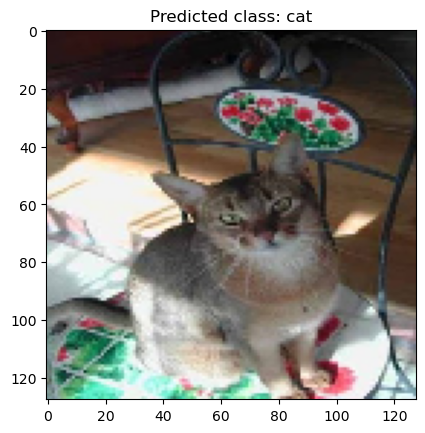

In [28]:
# Get prediction for the first cat image
image_path = cat_images[1]
results = get_pred(image_path)
class_id = int(np.squeeze(results['predictions']) > 0.5)

# Define your classes
classes = ['cat', 'dog']  # Ensure the order corresponds to how your model was trained

# Display the image with prediction
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
plt.imshow(img)
plt.title(f'Predicted class: {classes[class_id]}')
plt.show()

# Delete Model Endpoint

In [29]:
sess.delete_endpoint(pets_predictor.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: tensorflow-training-2023-11-22-15-26-32-780
